# Diseases Informed Neural Networks

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import deepxde as dde
import seaborn as sns

from deepxde.backend import tf
from scipy.integrate import odeint

sns.set_theme(style="whitegrid")

%matplotlib inline

## Model

$$
\begin{aligned}
\frac{dS}{dt} &= - \frac{\beta}{N}  S I \\
\frac{dI}{dt} &= \frac{\beta}{N} S I - \omega  I - \gamma I \\
\frac{dR}{dt} &= \omega I \\
\frac{dD}{dt} &= \gamma I \\
\end{aligned}
$$

- Susceptible (S): Individuals who have not been infected with COVID-19 and have not isolated themselves from the population
- Infected (I): Infectious individuals with COVID-19
- Recovered (R): Individuals who survived COVID-19
- Dead (D): Individuals who did not survive COVID-19

- $\beta$: Transmission Rate
- $\omega$: Rate at which Infected individuals become Recovered
- $\gamma$: Rate at which Infected individuals become Dead

## Initial Conditions

In [3]:
N = 1e6
beta = 0.5
omega = 1 / 14
gamma = 1 / 5
parameters_real = [beta, omega, gamma]

t = np.arange(0, 366, 7)[:, np.newaxis]

## Generate Data

In [4]:
def sird_model(
    t,
    N,
    beta,
    omega,
    gamma,
):
    def func(y, t):
        S, I, R, D = y
        dS = - beta / N * S * I
        dI = beta / N * S * I - gamma * I - omega * I
        dR = gamma * I
        dD =  omega * I
        return [dS, dI, dR, dD]
    
    S_0 = N - 1
    I_0 = 1
    R_0 = 0
    D_0 = 0
    y0 = [S_0, I_0, R_0, D_0]
    return odeint(func, y0, t)

In [5]:
y = sird_model(np.ravel(t), N, beta, omega,  gamma)
y_noise1 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.01
y_noise5 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.05
y_noise10 = y + np.random.normal(loc=0, scale=y.std(axis=0), size=y.shape) * 0.1

In [6]:
names = list("SIRD")
data_real = (
    pd.DataFrame(y, columns=names, index=t.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

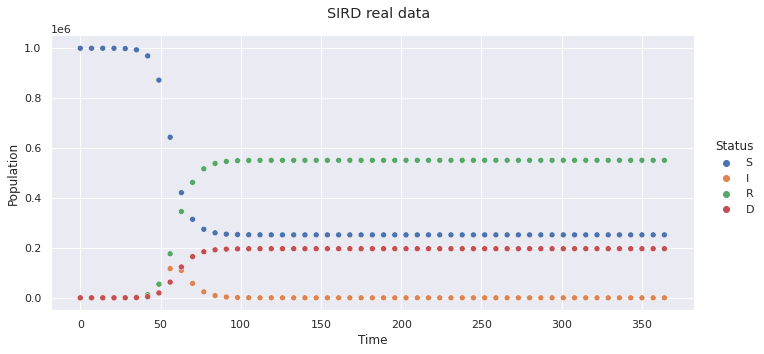

In [7]:
sns.set(rc={"figure.facecolor":"white"})
g = sns.relplot(data=data_real, x="time", y="population", hue="status", aspect=2)
g.set_axis_labels("Time", "Population")
g._legend.set_title("Status")
g.tight_layout(w_pad=1)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD real data")
# plt.savefig("SIRD_real.png", dpi=300)
plt.show()

## DINN

In [8]:
def dinn(data_t, data_y, N):    
    
    # Variables
    beta = tf.math.sigmoid(dde.Variable(0.1))
    omega = tf.math.sigmoid(dde.Variable(0.1))
    gamma = tf.math.sigmoid(dde.Variable(0.1))
    variable_list = [beta, omega, gamma]
    
    # ODE model
    def ODE(t, y):
        S = y[:, 0:1]
        I = y[:, 1:2]
        R = y[:, 2:3]
        D = y[:, 3:4]
        
        dS_t = dde.grad.jacobian(y, t, i=0)
        dI_t = dde.grad.jacobian(y, t, i=1)
        dR_t = dde.grad.jacobian(y, t, i=2)
        dD_t = dde.grad.jacobian(y, t, i=3)

        return [
            dS_t - (- beta / N * S * I),
            dI_t - (beta / N * S * I - gamma * I - omega * I),
            dR_t - (gamma * I),
            dD_t - (omega * I)
        ]
    
    # Geometry
    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])
    
    # Boundaries
    def boundary(_, on_initial):
        return on_initial
    
    # Initial conditions
    ic_S = dde.icbc.IC(geom, lambda x: N- 1, boundary, component=0)
    ic_I = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
    ic_R = dde.icbc.IC(geom, lambda x: 0, boundary, component=2)
    ic_D = dde.icbc.IC(geom, lambda x: 0, boundary, component=3)

    # Train data
    observe_S = dde.icbc.PointSetBC(data_t, data_y[:, 0:1], component=0)
    observe_I = dde.icbc.PointSetBC(data_t, data_y[:, 1:2], component=1)
    observe_R = dde.icbc.PointSetBC(data_t, data_y[:, 2:3], component=2)
    observe_D = dde.icbc.PointSetBC(data_t, data_y[:, 3:4], component=3)
    
    # Model
    data = dde.data.PDE(
        geom,
        ODE,
        [
            ic_S,
            ic_I,
            ic_R,
            ic_D,
            observe_S,
            observe_I,
            observe_R,
            observe_D
        ],
        num_domain=400,
        num_boundary=2,
        anchors=data_t,
    )
    
    net = dde.nn.FNN([1] + [128] * 3 + [4], "relu", "Glorot uniform")
    
    def feature_transform(t):
        t = t / data_t[-1, 0]
        return t

    net.apply_feature_transform(feature_transform)

    iterations = 50000
    model = dde.Model(data, net)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=4 * [1] + 4 * [1] + 4 * [1e1],
        external_trainable_variables=variable_list
    )
    variable = dde.callbacks.VariableValue(
        variable_list,
        period=5000,
        # filename="variables_sird.dat"
    )
    losshistory, train_state = model.train(
        iterations=iterations,
        display_every=10000,
        callbacks=[variable]
      )
    # dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    return model, variable

In [9]:
model, variable = dinn(t, y, N)

Compiling model...
Building feed-forward neural network...
'build' took 0.036716 s



/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "
/home/aoguedao/mambaforge/envs/pinn/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2022-10-12 12:24:12.709288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


'compile' took 0.534678 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.94e-09, 1.20e-03, 2.99e-04, 2.93e-04, 1.00e+12, 1.00e+00, 0.00e+00, 0.00e+00, 2.09e+12, 6.18e+09, 2.46e+12, 3.14e+11]    [1.94e-09, 1.20e-03, 2.99e-04, 2.93e-04, 1.00e+12, 1.00e+00, 0.00e+00, 0.00e+00, 2.09e+12, 6.18e+09, 2.46e+12, 3.14e+11]    []  


2022-10-12 12:24:13.220681: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


KeyboardInterrupt: 

## Postprocessing

In [ ]:
parameter_names = [
  "beta",
  "omega",
  "gamma",
]
errors = (
    pd.DataFrame(
        {
            "real": parameters_real,
            "predicted": variable.value
        },
        index=parameter_names
    )
    .assign(
        relative_error=lambda x: (x["real"] - x["predicted"]).abs() / x["real"] * 100
    )
)
errors.to_excel("SIRD_errors.xlsx")
errors

,real,predicted,relative_error
beta,0.500000,0.514282,2.856469
omega,0.071429,0.073270,2.577646
gamma,0.200000,0.206412,3.205986


In [ ]:
full_t = np.arange(0, 366)[:, np.newaxis]
y_pred = model.predict(full_t)
data_pred = (
    pd.DataFrame(y_pred, columns=names, index=full_t.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)
data_pred.head()

,time,status,population
0,0,S,999962.0000
1,1,S,999936.1250
2,2,S,999910.4375
3,3,S,999884.6875
4,4,S,999858.6875


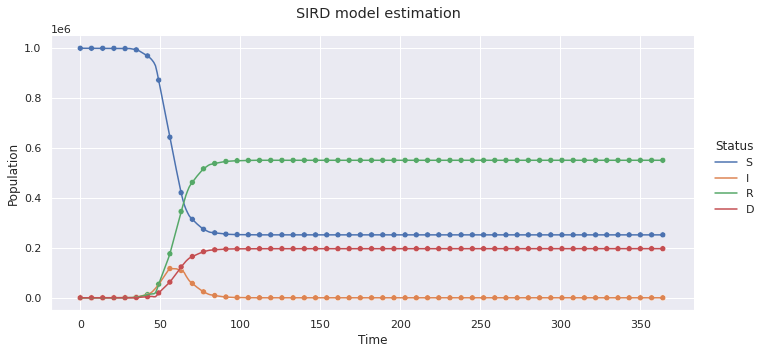

In [ ]:
sns.set(rc={"figure.facecolor":"white"})

g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
)

sns.scatterplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)


(
    g.set_axis_labels("Time", "Population")
      .set_titles("Zone {row_name}")
      .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD model estimation")
plt.savefig("SIRD_estimation.png", dpi=300)
plt.show()

In [ ]:
dde.metrics.l2_relative_error(y, model.predict(t))

2022-08-07 18:03:45.808553: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0.0002186510047609107

In [ ]:
dde.metrics.mean_squared_error(y, model.predict(t))

5823.651947318222